# Import functions and set TF_USE_LEGACY_KERAS = 1 (necessary only for tensorflow version >= 2.16.0)

In [1]:
import os

# Only needed for tensorflow versions greater than 2.16.0
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import sys
import joblib
sys.path.insert(1,"../")
from data import write_data, gen_fcst_norm 
import numpy as np
from config import get_data_paths


2025-09-20 00:51:58.484650: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-20 00:51:58.540118: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-20 00:51:59.777543: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## We retrieve the data paths set in [**config/data_paths.yaml**](https://github.com/snath-xoc/cGAN_tutorial/blob/main/config/data_paths.yaml) and check that they are correctly set. We also set the year that is used to generate normalisation constants

In [16]:
data_paths = get_data_paths()
CONSTANTS_PATH = data_paths["GENERAL"]["CONSTANTS_PATH"]
FCSTNorm_year = "2018"

print("Sanity check that these data paths are correctly set:\n")
print("FORECAST_PATH:",data_paths["GENERAL"]["FORECAST_PATH"])
print("CONSTANTS_PATH:",data_paths["GENERAL"]["CONSTANTS_PATH"])
print("TRUTH_PATH:",data_paths["GENERAL"]["TRUTH_PATH"])
print("TFRecords path:",data_paths["TFRecords"]["tfrecords_path"])

Sanity check that these data paths are correctly set:

FORECAST_PATH: /network/group/aopp/predict/TIP021_MCRAECOOPER_IFS/IFS-regICPAC-meansd/
CONSTANTS_PATH: /network/group/aopp/predict/TIP017_COOPER_SURFACE/cGAN/ICPAC/6h_IMERG_v6_Andrew/constants/
TRUTH_PATH: /network/group/aopp/predict/AWH024_COOPERNATH_IFS/IFS/IMERG_V07/ICPAC_region/6h/
TFRecords path: /network/group/aopp/predict/AWH026_NATH_GFSAIMOD/cGAN/tfrecords_course/


# Forecast normalisation constants
### Typically for AI approaches, training and optimisation as well as inference works best when the values are normalised in a manner that retains the original distirbution. We therefore calculate a set of forecast normalisation constants for the region with which to normalise the variables with. These normalisation constants include the mean, std, min and max. 

### We normalise accordingly:
#### a) Precipitation variables of total precipitation (tp) and convective precipitation (cp) follow a log normalisation (i.e. log10(1+x) ).
#### b) 2m temperature (t2m) and surface pressure (sp) are reasonable normally distributed so we use a simple standard normalisation of (x-mean)/std.
#### c) Other variables are bounded to be non-negative (e.g., cape, tclw, tciw, tcrw, tcwv,tcw) and divided through by their maximum: x/max.
#### d) Wind (both u and v components) can be negative and are therefore divided by their absolute maximum: x/maxima(abs(min),abs(max)).
#### e) It is worth noting that Shortwave Solar Radiation (ssr) is an accumulated variables and needs to be converted from per hour to per second (i.e. x/3600).
#### f) Medium Cloud Cover (mcc) does not require any normalisation (as it is a fractional value bounded at 0-1).

In [2]:
##Mean, STD, min, max
if not os.path.exists(CONSTANTS_PATH+f"FCSTNorm{FCSTNorm_year}.pkl"):
    gen_fcst_norm(year=FCSTNorm_year)
    fcstNorm = joblib.load(CONSTANTS_PATH+f"FCSTNorm{FCSTNorm_year}.pkl")
else:
    fcstNorm = joblib.load(CONSTANTS_PATH+f"FCSTNorm{FCSTNorm_year}.pkl")

print(fcstNorm)
    

{'cape': {'min': 0.0, 'max': 12028.97, 'mean': 372.25190070517834, 'std': 634.6625669909214}, 'cp': {'min': 0.0, 'max': 11.575001, 'mean': 0.07430827387592304, 'std': 0.15727741289177508}, 'mcc': {'min': 0.0, 'max': 1.0, 'mean': 0.1449043023444736, 'std': 0.15871610393337535}, 'sp': {'min': 65720.24, 'max': 103549.266, 'mean': 94920.06952099419, 'std': 5503.212221379535}, 'ssr': {'min': -0.0431156, 'max': 924.5827, 'mean': 196.8274811061243, 'std': 235.30287313931277}, 't2m': {'min': 270.85034, 'max': 321.96042, 'mean': 298.3595823336004, 'std': 5.641285692771801}, 'tciw': {'min': 0.0, 'max': 2.5885322, 'mean': 0.014063224684635873, 'std': 0.028363458486443126}, 'tclw': {'min': 0.0, 'max': 3.4733133, 'mean': 0.03823531449178857, 'std': 0.04313131040707701}, 'tcrw': {'min': 0.0, 'max': 14.966368, 'mean': 0.009420234312671727, 'std': 0.022581907459965727}, 'tcw': {'min': 0.47369844, 'max': 123.179535, 'mean': 30.90023667667402, 'std': 13.09838759314808}, 'tcwv': {'min': 0.4736635, 'max':

# Data Generator
### As mentioned in the data module directory, a key part to the data load-in is the ```DataGenerator``` class from the [**data/data_generator.py**](https://github.com/snath-xoc/cGAN_tutorial/blob/main/data/data_generator.py) file. 

### The ```DataGenerator``` calls the ```load_fcst_truth_batch``` function from [**data/data.py**](https://github.com/snath-xoc/cGAN_tutorial/blob/main/data/data.py#L157) that for a given date will:<br>1) Load in all desired forecast variables (i.e., using ```load_fcst_stack```)<br>2) Load in the truth variables (i.e., ```load_truth_and_mask```)<br> 

### Once all file paths specified in [**config/data_paths.yaml**](https://github.com/snath-xoc/cGAN_tutorial/blob/main/config/data_paths.yaml) and [**config/local_config.yaml**](https://github.com/snath-xoc/cGAN_tutorial/blob/main/config/local_config.yaml) are set properly in the config directory we can initialise the data generator and visualise that everything looks alright

### Initialisation of the data generator:

#### First import the DataGenerator alongside the forecast fields (```all_fcst_fields```) from the data module. We also check which dates are available for the example year 2018 and fcst time horizon of 30 hour to 54 hour ahead using the ```get_dates``` function

In [13]:
##Example load-in
from data import DataGenerator, all_fcst_fields, get_dates

print("Looking into getting dates for the forecast fields:\n", all_fcst_fields,"\n")

year = 2018
start_hour = 30
end_hour = 54
dates = get_dates(year, start_hour, end_hour)

print(f"Available dates for the year {year} and forecast lead times of {start_hour} to {end_hour} are:", dates)


Looking into getting dates for the forecast fields:
 ['cape', 'cp', 'mcc', 'sp', 'ssr', 't2m', 'tciw', 'tclw', 'tcrw', 'tcw', 'tcwv', 'tp', 'u700', 'v700'] 

Available dates for the year 2018 and forecast lead times of 30 to 54 are: ['20180101', '20180102', '20180103', '20180104', '20180105', '20180106', '20180107', '20180108', '20180109', '20180110', '20180111', '20180112', '20180113', '20180114', '20180115', '20180116', '20180117', '20180118', '20180119', '20180120', '20180121', '20180122', '20180123', '20180124', '20180125', '20180126', '20180127', '20180128', '20180129', '20180130', '20180131', '20180201', '20180202', '20180203', '20180204', '20180205', '20180206', '20180207', '20180208', '20180209', '20180210', '20180211', '20180212', '20180213', '20180214', '20180215', '20180216', '20180217', '20180218', '20180219', '20180220', '20180221', '20180222', '20180223', '20180224', '20180225', '20180226', '20180227', '20180228', '20180301', '20180302', '20180303', '20180304', '20180305'

### Now we instantiate the DataGenerator, the main arguments are:

#### dates: list, positional argument that is a list of dates to load in<br> fcst_fields: list, which forecast variables to load in (we use all the forecast fields as printed above)<br> start_hour: int, the first lead time to load in (we usually use 30 hours)<br> end_hour: int, the last lead time up to which to load in (usually 54 hours)<br> batch_size: int<br> shuffle: Boolean<br> constants: Boolean, whether to use land-sea mask and elevation constants<br> fcst_norm: Boolean, whether to normalise forecast variables

In [4]:
test_idx_till = 20

dgc = DataGenerator(dates[:test_idx_till],
                       fcst_fields=all_fcst_fields,
                                start_hour=start_hour,
                                end_hour=end_hour,
                                batch_size=1,
                                log_precip=True,
                                shuffle=False,
                                constants=True,
                                fcst_norm=True)

### Next we draw a sample by calling the ```__getitem__``` function of the ```DataGenerator```. The sample itself should be a tuple with:
#### 1) A dictionary of:<br>&nbsp;&nbsp; a) lo_res_inputs: the forecast inputs going into the GAN, this is an array of size (```batch_size, lat, lon, n_variables```). For our domain ```lat=384``` and ```lon=352```. Our forecast list printed above has 14 variables, for each variable we take the ensemble mean and standard deviation at the lead time of interest, and the lead time of interest + 6. This means that we have ```n_variables=14*2*2=56```.<br>&nbsp;&nbsp; b) hi_res_inputs: constant inputs of elevation and land-sea mask, this is an array of size (```batch_size, lat, lon, 2```)
#### 2)  A dictionary of:<br>&nbsp;&nbsp; a) output: truth data, an array of (```batch_size, lat, lon```).<br>&nbsp;&nbsp; b) mask: mask containing invalid points in the truth data, an array of (```batch_size, lat, lon```)

In [22]:
sample = dgc.__getitem__(0)

keys = [k for k in sample[0].keys()]
shapes = [sample[0][k].shape for k in sample[0].keys()]
print("Sample consisting of a tuple has been retrieved. Keys for the first component are:", keys)
print("The corresponding shapes are:")
for key, shape in zip(keys,shapes):
    print(key,":",shape)
keys = [k for k in sample[1].keys()]
shapes = [sample[1][k].shape for k in sample[1].keys()]

print("\n")
print("Keys for the second component are:", keys)
print("The corresponding shapes are:")
for key, shape in zip(keys,shapes):
    print(key,":",shape)

Sample consisting of a tuple has been retrieved. Keys for the first component are: ['lo_res_inputs', 'hi_res_inputs']
The corresponding shapes are:
lo_res_inputs : (1, 384, 352, 56)
hi_res_inputs : (1, 384, 352, 2)


Keys for the second component are: ['output', 'mask']
The corresponding shapes are:
output : (1, 384, 352)
mask : (1, 384, 352)


### Next we visualise the loaded in values, an easy first one to check are the constant fields of elevation and land-sea mask

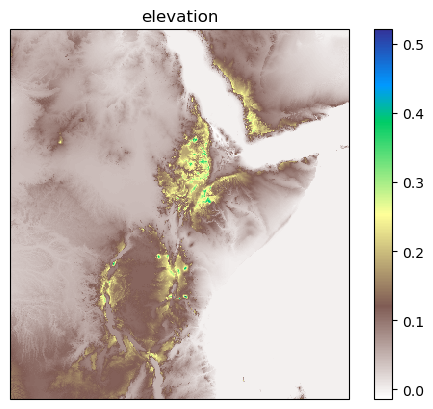

Text(0.5, 1.0, 'land-sea mask')

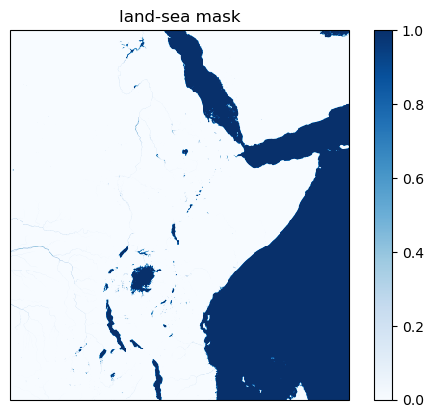

In [32]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

ax = plt.axes(projection = ccrs.PlateCarree())

lats = np.arange(-13.65,24.65+0.1,0.1)
lons = np.arange(19.15,54.25+0.1,0.1)

mesh = ax.pcolormesh(lons, lats, sample[0]['hi_res_inputs'][0,:,:,0], cmap='terrain_r')
plt.colorbar(mesh)
plt.title('elevation')
plt.show()
plt.close()

ax = plt.axes(projection = ccrs.PlateCarree())

mesh = ax.pcolormesh(lons, lats, sample[0]['hi_res_inputs'][0,:,:,1], cmap='Blues')
plt.colorbar(mesh)
plt.title('land-sea mask')

### Now we can try a variable such as surface pressure

Text(0.5, 1.0, 'sp mean')

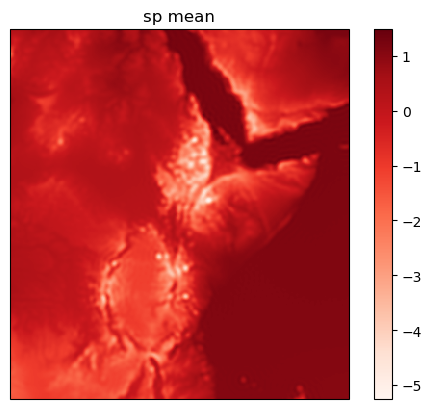

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# plot the variable mean for the first time ste
# feel free to change the variables
var = "sp"
idx = all_fcst_fields.index(var)*4

ax = plt.axes(projection = ccrs.PlateCarree())

lats = np.arange(-13.65,24.65+0.1,0.1)
lons = np.arange(19.15,54.25+0.1,0.1)

mesh = ax.pcolormesh(lons, lats, sample[0]['lo_res_inputs'][0,:,:,idx], cmap='Reds')
plt.colorbar(mesh)
plt.title(f"{var} mean")


### Now we can start writing the tfrecord files by calling the ```write_data``` function. Good to know beforehand:
#### The ```write_data``` function is loaded from ```tfrecords_generator.py```. We write tfrecords into a file using the naming convention:

#### {year}_{leadtime}.{class}.tfrecords

#### Where the class represents a certain range of rainfall. The number of classes is specified under ```CLASSES``` in ```L22``` of the ```tfrecords_generator.py```, with the respective class bins specified under ```bins``` in ```L226```.

In [2]:
from data import write_data

years = [2018]

for year in years:
    write_data(year)
    


Samples per image: 8
Doing time index 30


100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:25<00:00,  3.20s/it]


Doing time index 36


100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:25<00:00,  3.19s/it]


Doing time index 42


100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:25<00:00,  3.21s/it]


Doing time index 48


100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:26<00:00,  3.27s/it]


# Sanity read-in and batch check for once data is created

In [7]:
import tensorflow as tf
from data import _parse_batch

tfrecords_path = data_paths["TFRecords"]["tfrecords_path"]

dataset = tf.data.TFRecordDataset(os.path.join(tfrecords_path,'2018_36.3.tfrecords'),compression_type='GZIP')




In [8]:

dataset = dataset.map(lambda x: _parse_batch(x, insize = (128,128,56), consize=(128,128,2), outsize=(128,128,1)))
test = dataset.repeat().batch(2)      
for inputs,outputs in test.take(1).as_numpy_iterator():

    print(inputs['lo_res_inputs'].shape)

    break

(2, 128, 128, 56)


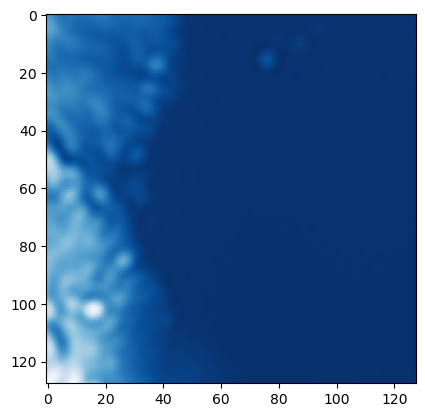

In [12]:
import matplotlib.pyplot as plt
from data import all_fcst_fields

var = "sp"
idx = all_fcst_fields.index(var)*4
plt.imshow(inputs['lo_res_inputs'][0,:,:,idx],cmap='Blues')